In [77]:
# Data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SARIMAX from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For splitting data and error metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [78]:
data = pd.read_csv('solar_power_data.csv')

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

data.head()


,date,humidity,solar_irradiance,temperature,energy_production
0,2022-01-01,62.483571,519.584526,19.584632,45.939761
1,2022-01-02,59.653418,407.333812,16.585660,51.806938
2,2022-01-03,63.927819,551.165919,19.889962,65.616643
3,2022-01-04,68.648958,345.248763,18.223795,38.991621
4,2022-01-05,60.207166,623.584561,19.291879,60.911264


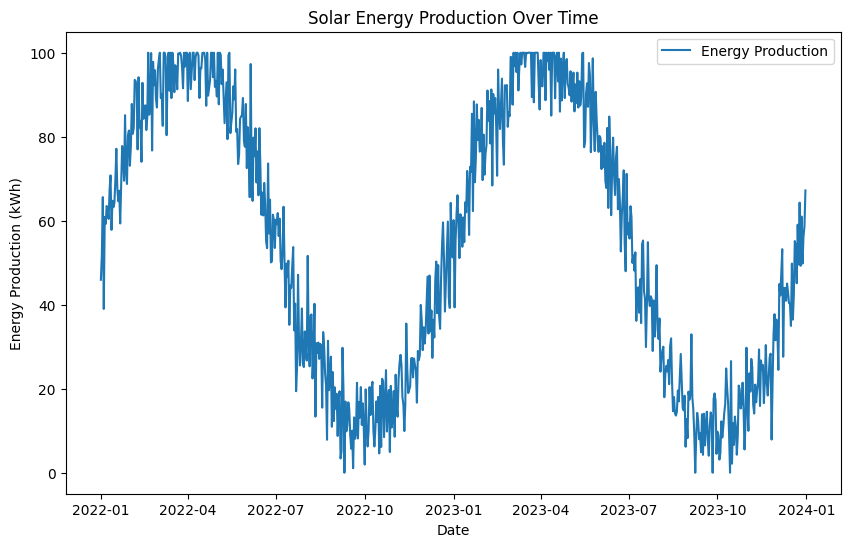

In [86]:
# Plot the solar energy production over time
plt.figure(figsize=(10,6))
plt.plot(data['date'], data['energy_production'], label='Energy Production')
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Solar Energy Production Over Time')
plt.legend()
plt.show()

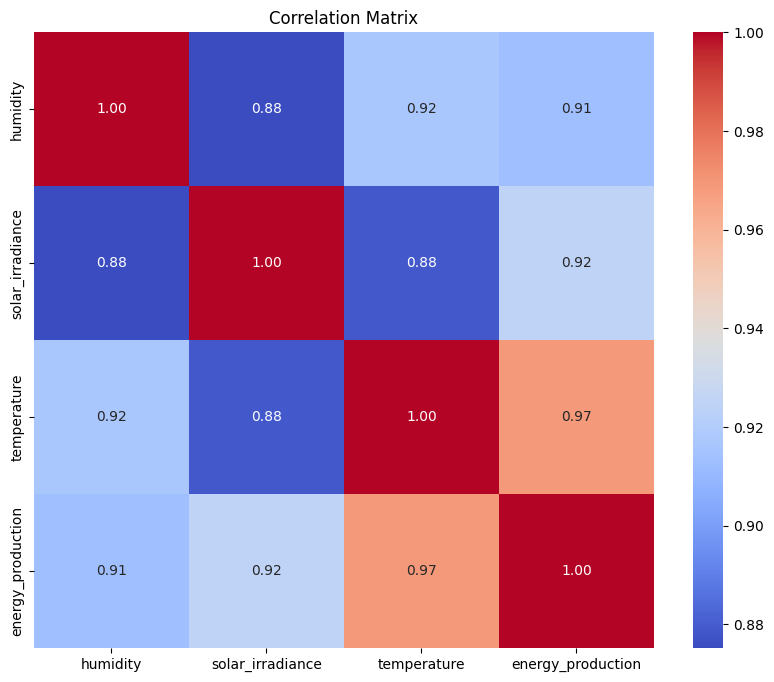

In [80]:
# Filter out non-numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


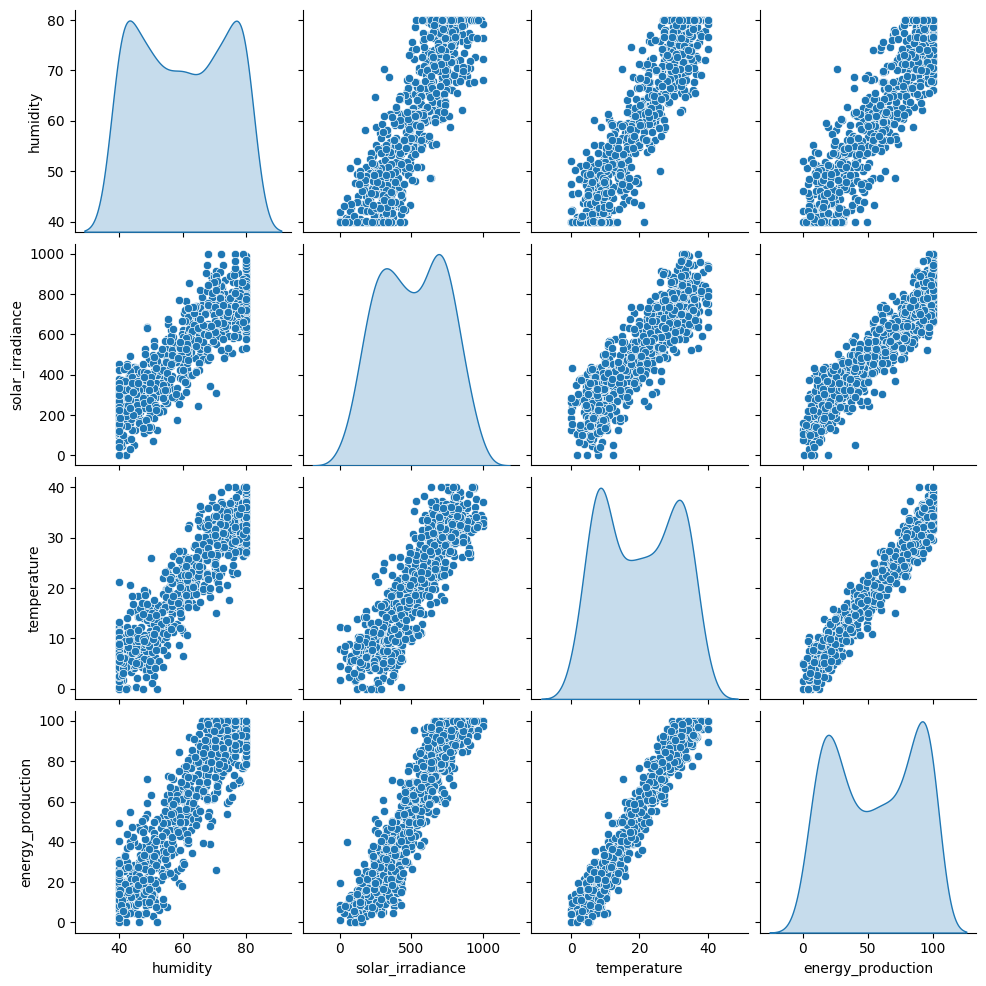

In [81]:
# Plot pairwise relationships between features and target variable
sns.pairplot(data, diag_kind='kde')
plt.show()

In [82]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

# Split target (y) and exogenous variables (X) for both train and test sets
y_train = train_data['energy_production']
X_train = train_data[['humidity', 'temperature', 'solar_irradiance']]

y_test = test_data['energy_production']
X_test = test_data[['humidity', 'temperature', 'solar_irradiance']]


In [83]:
# Define the SARIMAX model with exogenous variables
model = SARIMAX(y_train,
                exog=X_train,
                order=(1, 1, 1),  # ARIMA parameters: p, d, q
                seasonal_order=(1, 1, 1, 12),  # Seasonal: P, D, Q, m (assuming monthly seasonality)
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
sarimax_result = model.fit(disp=False)

# Print model summary
print(sarimax_result.summary())


                                     SARIMAX Results                                      
Dep. Variable:                  energy_production   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1728.344
Date:                            Sun, 29 Sep 2024   AIC                           3472.688
Time:                                    12:57:53   BIC                           3507.268
Sample:                                         0   HQIC                          3486.194
                                            - 584                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
humidity            -0.4695      0.050     -9.346      0.000      -0.568      -0.371
temperature      

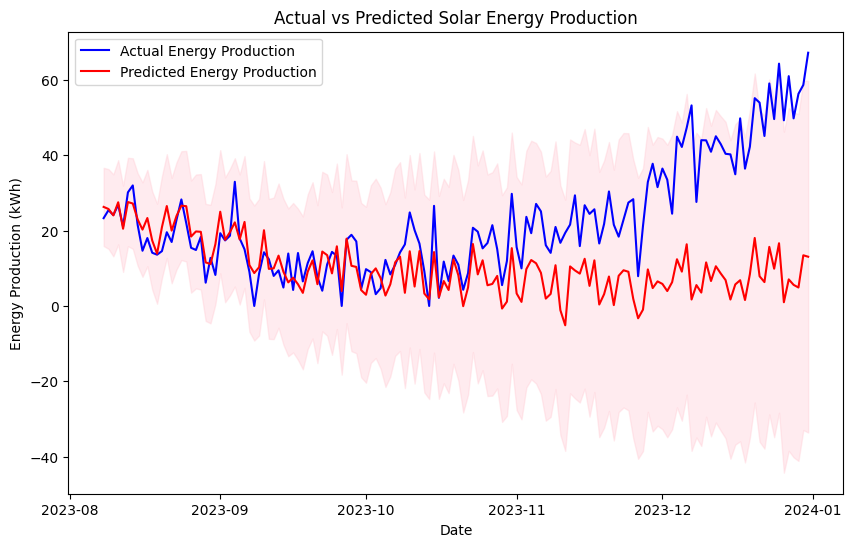

In [88]:
# Forecast the values for the test set (predict using exogenous variables)
forecast = sarimax_result.get_prediction(start=test_data.index[0], end=test_data.index[-1], exog=X_test)

# Get predicted mean values
predicted_values = forecast.predicted_mean
# Plot actual vs predicted energy production
plt.figure(figsize=(10,6))
plt.plot(test_data['date'], y_test, label='Actual Energy Production', color='blue')
plt.plot(test_data['date'], predicted_values, label='Predicted Energy Production', color='red')
plt.fill_between(test_data['date'],
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Energy Production (kWh)')
plt.title('Actual vs Predicted Solar Energy Production')
plt.legend()
plt.show()


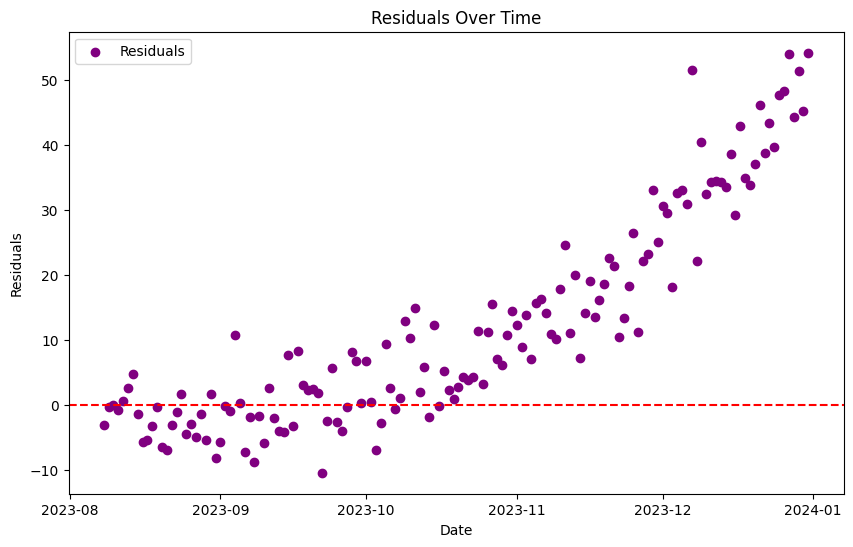

In [91]:
# Scatter plot of residuals over time
plt.figure(figsize=(10,6))
plt.scatter(test_data['date'], y_test - predicted_values, label='Residuals', color='purple')
plt.axhline(0, linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

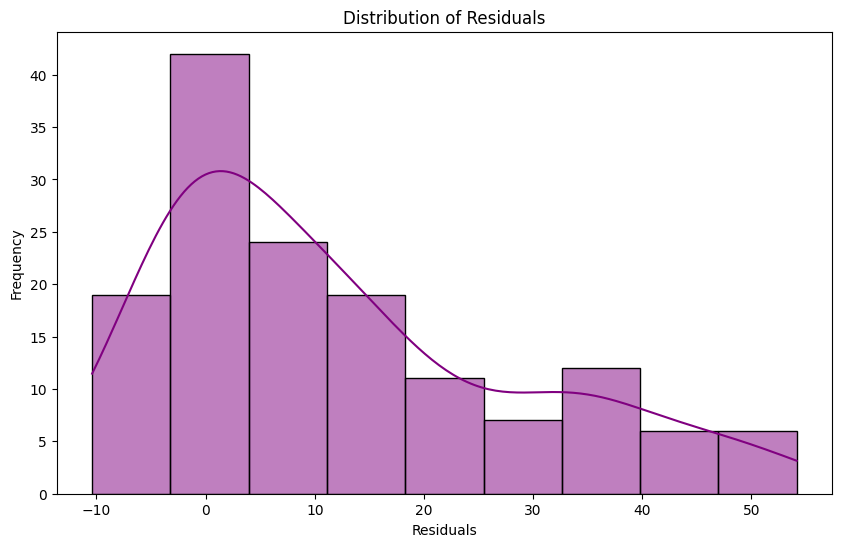

In [73]:
# Plot the distribution of residuals
plt.figure(figsize=(10,6))
sns.histplot(y_test - predicted_values, kde=True, color='purple')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

In [74]:
# Calculate RMSE (Root Mean Squared Error)
rmse = math.sqrt(mean_squared_error(y_test, predicted_values))
print(f'RMSE: {rmse}')

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, predicted_values)
print(f'MAE: {mae}')

# Calculate R² score
r2 = r2_score(y_test, predicted_values)
print(f'R² Score: {r2}')


RMSE: 20.328218307030625
MAE: 14.25969383582499
R² Score: -0.8547207707976279


In [75]:
# Calculate accuracy in percentages
accuracy_percentage = abs(r2 * 100)
print(f'Accuracy: {accuracy_percentage:.2f}%')

Accuracy: 85.47%
